# **Installations**


In [1]:
!pip install category_encoders
!pip install eli5

     -------------------------------------- 216.2/216.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107768 sha256=468ba14c053941355e20083814275415eb05190a0035c1a9c28089b21bcd0422
  Stored in directory: c:\users\roland\appdata\local\pip\cache\wheels\7b\26\a5\8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


# Bank remarketing

In [2]:
# Import libraries 
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import xgboost

import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
import joblib
from keras.callbacks import EarlyStopping
import eli5
from eli5.sklearn import PermutationImportance

### 1. Loading data and holding a short Expanatory Data Analysis

In [3]:
# Read data
proj_dir = 'C:/Users/Roland/General/Downloads/home'
data_file = 'bank deposit data.csv'
os.chdir(proj_dir)
data = pd.read_csv(data_file, sep=';')
display(data.head(3))
display('There are {} observations with {} features'.format(data.shape[0], data.shape[1]))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


'There are 41188 observations with 21 features'

In [4]:
dtypes = data.dtypes # Initialize lists for categorical and numerical features
cat_features = []
num_features = []

# Loop through each column in the dataset. If data type is object its categorical else numerical
for col in data.columns:
    if dtypes[col] == 'object':
        cat_features.append(col)
    elif dtypes[col] in ['int64', 'float64']:
        num_features.append(col)

# Print the results
print("Categorical features:", len(cat_features))
print(cat_features)
print("Numerical features:", len(num_features))
print(num_features)

Categorical features: 11
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Numerical features: 10
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### 1. Explore categorical features (EDA)

In [5]:
# Build a function to show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();

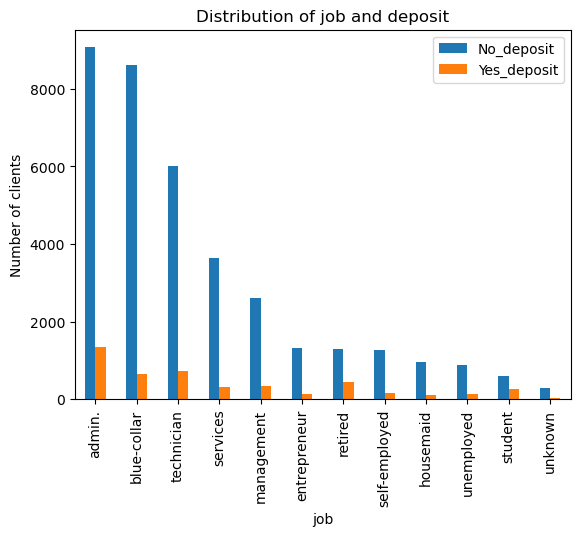

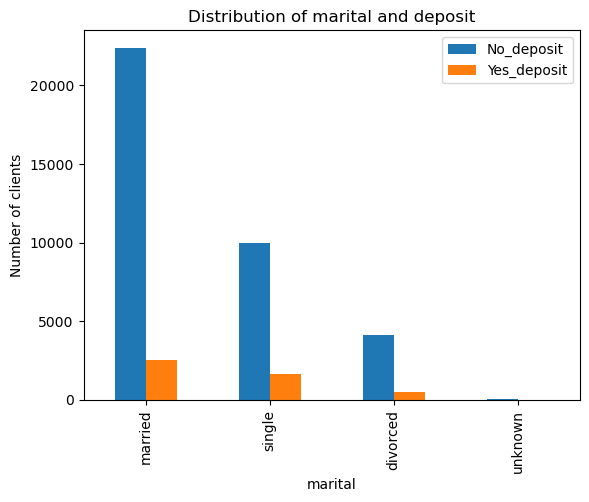

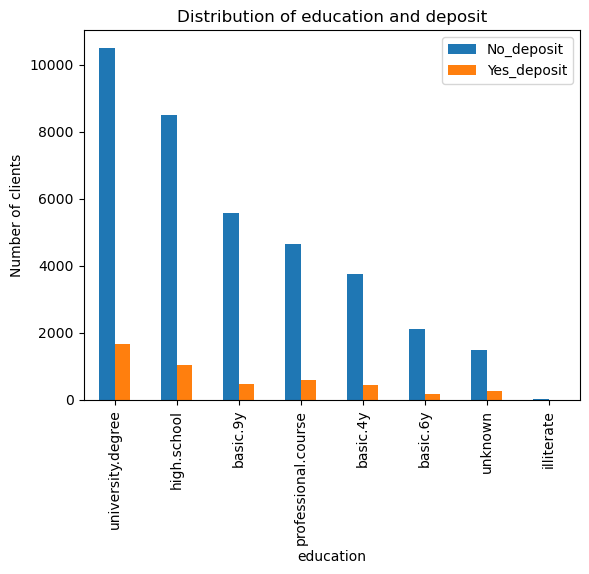

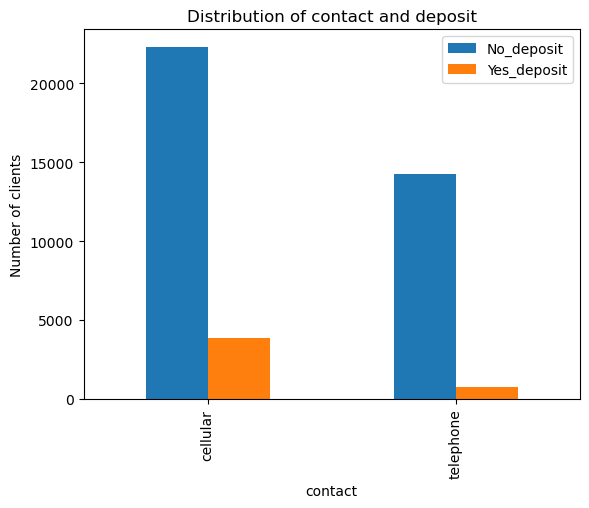

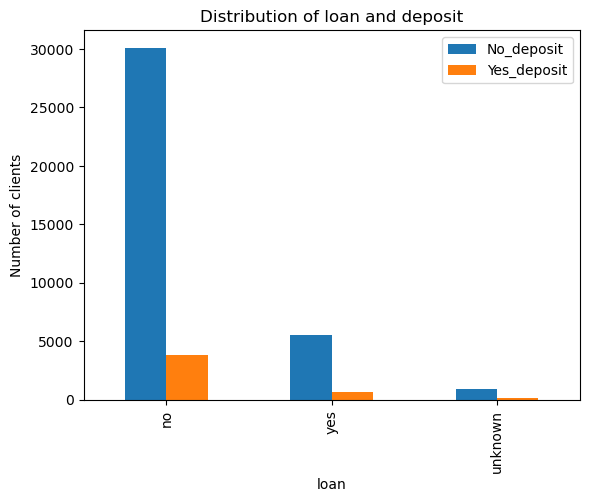

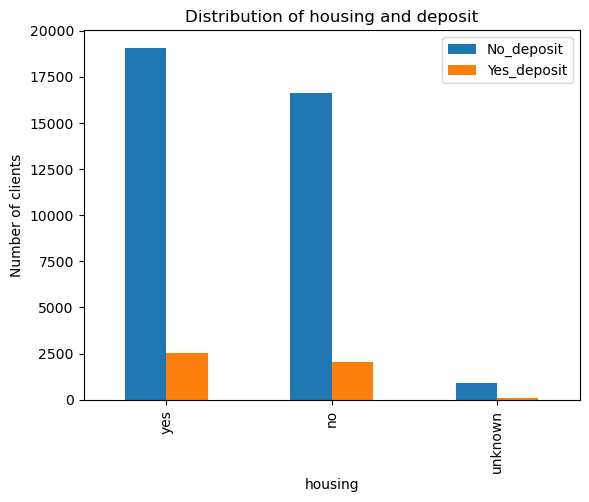

(None, None, None, None, None, None)

In [6]:
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

### Explore numerical features (EDA)

In [7]:
# Convert target variable into numeric
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

In [8]:
# Build correlation matrix
corr = data.corr()
corr.style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


### 2. Processing

In [9]:
# Replacing values with binary ()
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact 
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 

# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index 
data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')
data.age = np.log(data.age)

# less space
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.pdays = data.pdays.astype('uint8')

# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable 
data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)

# Drop tranfromed features
data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

In [10]:
'''Drop the dublicates'''
data.drop_duplicates(inplace=True) 

In [11]:
'''Convert Duration Call into 5 category'''
def duration(data):
    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration'] = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration'] = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 645), 'duration'] = 4
    data.loc[data['duration']  > 645, 'duration'] = 5
    return data
duration(data);

In [12]:
''' Target encoding for two categorical feature '''
# save target variable before transformation
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)

In [13]:
'''Check numerical data set'''
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,4.025352,0.101565,0.102490,1,0,0,0,3,1,0,...,0,1,0,0,0,0,1,0,0,0
1,4.043051,0.101565,0.108389,0,0,0,0,2,1,0,...,0,1,0,0,0,0,1,0,0,0
2,3.610918,0.101565,0.108389,1,1,0,0,3,1,0,...,0,1,0,0,0,0,1,0,0,0


(41175, 44)

(41175,)

'We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

In [14]:
numeric_dataset.to_excel('revised_dataset.xlsx')

### 3. Building a pipline for Cross Validation and Grid Search procedures (search for optimal parameters of the model)

In [15]:
''' Split data on train and test'''
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()

0

In [16]:
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'check the shape of splitted train and test sets'

(32940, 44)

(32940,)

(8235, 44)

(8235,)

In [17]:
# define the neural network model
num_features=X_train.shape[1]

def create_nn(activation='relu', optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(10, input_dim=num_features, activation=activation.lower()))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu',kernel_regularizer='l2'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [18]:
'''Build pipline of classifiers'''
# set all CPU
n_jobs = -1
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])
# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
# BaggingClassifier
# note we use SGDClassifier as classier inside BaggingClassifier
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])
# SGDClassifier
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])
pipe_nn = Pipeline([('NN', KerasClassifier(build_fn=create_nn, epochs=2, batch_size=16, activation='relu',callbacks=[EarlyStopping(monitor='accuracy', patience=3)] )    )])

In [19]:
pipeline = Pipeline([
    ('NN', KerasClassifier(build_fn=create_nn))
])

# Use get_params() to check the available parameters for the KerasClassifier estimator
print(pipeline.get_params()['NN'].get_params().keys())
print(pipe_nn.get_params().keys())
# Access the activation function of the first layer of the keras model
# activation_fn = pipeline.get_params()['NN'].model.get_config()['layers'][0]['config']['activation']
# print(activation_fn)
print(pipe_nn.get_params().keys())

dict_keys(['build_fn'])
dict_keys(['memory', 'steps', 'verbose', 'NN', 'NN__epochs', 'NN__batch_size', 'NN__activation', 'NN__callbacks', 'NN__build_fn'])
dict_keys(['memory', 'steps', 'verbose', 'NN', 'NN__epochs', 'NN__batch_size', 'NN__activation', 'NN__callbacks', 'NN__build_fn'])


In [20]:
'''Set parameters for Grid Search '''
# set number 
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# set for SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'], 
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]
#set for Neural net
grid_params_nn = [{
                   'NN__batch_size': [8, 16,32,128],
                   'NN__epochs': [2, 4, 8],
                   'NN__optimizer': ['adam', 'rmsprop'],
                   'NN__activation': ['relu', 'sigmoid']
}]

In [21]:
'''Grid search objects'''
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv) 
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)
# for NeuralNet
gs_nn = GridSearchCV(pipe_nn, param_grid=grid_params_nn,
                     scoring='accuracy', cv=cv)

In [22]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd, gs_nn]

# look_for = [gs_nn]

# dict for later use 
model_dict = {0:'Neural Net', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier', 5:'SGD Class', 6: 'Logistic_reg'}

In [23]:
def save_best_model(model, model_name):
  directory = "./save_models/"
  # Check if the directory exists
  if not os.path.exists(directory):
    # Create the directory if it doesn't exist
    os.makedirs(directory)
  file_path = directory + model_name +'.pkl'
  joblib.dump(model, file_path)
  

In [24]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc
        save_best_model(model.best_estimator_,model_dict[index])


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Neural Net
---------------------------------------------
best params {'lr__C': 0.6, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.9092592592592593
---------------------------------------------
ROC_AUC is 0.9216482278347329 and accuracy rate is 0.905525197328476
It lasted for 84.2 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.9035822707953857
---------------------------------------------
ROC_AUC is 0.926898425815701 and accuracy rate is 0.9038251366120219
It lasted for 37.787 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn
--------------------------------------------

### 5. The choice of the most effective model, build learninig curve rate


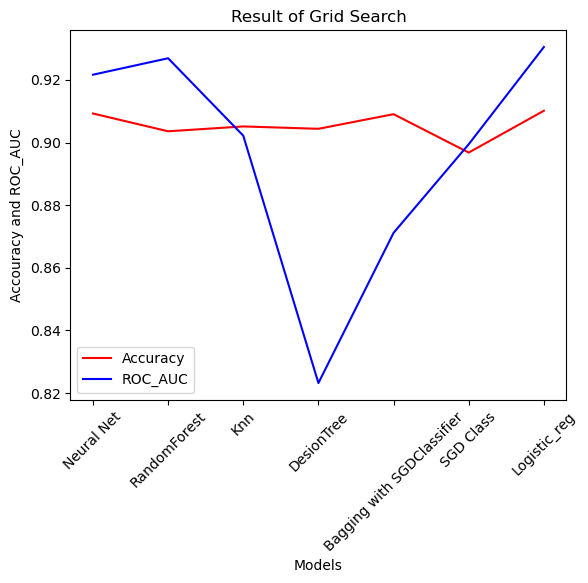

In [25]:
plt.plot(model_dict.values(), result_acc.values(), c='r')
plt.plot(model_dict.values(), result_auc.values(), c='b')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accouracy and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.show();

In [26]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Neural Net,0.909259,0.921648
1,RandomForest,0.903582,0.926898
2,Knn,0.905131,0.902178
3,DesionTree,0.904372,0.823199
4,Bagging with SGDClassifier,0.909047,0.871149
5,SGD Class,0.896782,0.899445
6,Logistic_reg,0.910140,0.930486


#### Best model 
Our best performed model with ROC_AUC (0.9269) metric is ** Random forest **. 
This classifier could achive accuracy rate 0.903 that is average accuracy among all classifiers (0.904).

We can build graph to check RandomForestClassifier performatce with OOB score to be sure that critical hyperparametr was correctly selected during Grid Search. 
As you may see it almost the same - 80 estimators with best ROC_AUC score and 90 estimators with maximun of OOB score


100%|██████████| 39/39 [00:25<00:00,  1.54it/s]


'max oob 0.9044323011536126 and number of estimators 90'

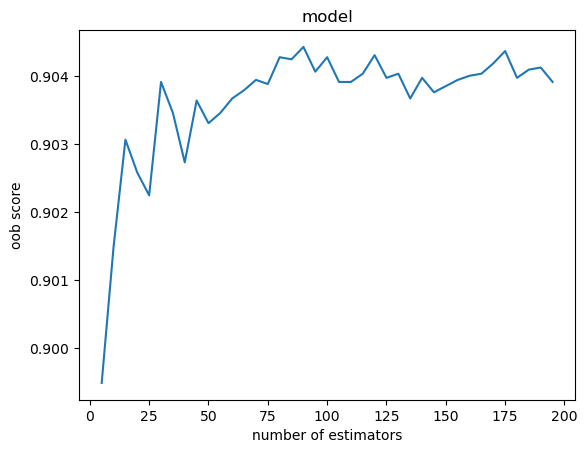

In [27]:
def graph(model, X_test, y_test):
    obb = []
    est = list(range(5, 200, 5))
    for i in tqdm(est):
        random_forest = model(n_estimators=i, criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3,)
        random_forest.fit(X_train, y_train)
        obb.append(random_forest.oob_score_)
    display('max oob {} and number of estimators {}'.format(max(obb), est[np.argmax(obb)]))
    plt.plot(est, obb)
    plt.title('model')
    plt.xlabel('number of estimators')
    plt.ylabel('oob score')
    plt.show();
    
graph(RandomForestClassifier, X_test, y_test)

  0%|          | 0/6 [00:00<?, ?it/s]

206/206 [==============================] - 0s 585us/step


 17%|█▋        | 1/6 [00:05<00:28,  5.62s/it]

206/206 [==============================] - 0s 771us/step


 33%|███▎      | 2/6 [00:13<00:26,  6.73s/it]

206/206 [==============================] - 0s 571us/step


 50%|█████     | 3/6 [00:22<00:24,  8.04s/it]

206/206 [==============================] - 0s 575us/step


 67%|██████▋   | 4/6 [00:34<00:19,  9.56s/it]

206/206 [==============================] - 0s 561us/step


 83%|████████▎ | 5/6 [00:48<00:11, 11.14s/it]

206/206 [==============================] - 0s 576us/step


100%|██████████| 6/6 [01:04<00:00, 10.76s/it]


'max accuracy 0.9159077109896782 and number of epochs 6'

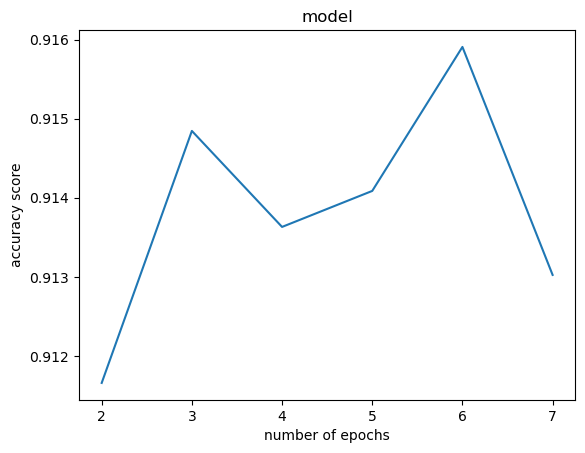

In [28]:
# Applying for neural net as well 
def graph(model, X_train, y_train, X_val, y_val):
    acc = []
    est = list(range(2, 8))
    model = joblib.load('./save_models/Neural Net.pkl')
    for i in tqdm(est):
        keras_model = KerasClassifier(build_fn=create_nn, epochs=i, batch_size=10, verbose=0)
        keras_model.fit(X_train, y_train, validation_data=(X_val, y_val))
        y_pred = keras_model.predict(X_val)
        acc.append(accuracy_score(y_val, y_pred))
    display('max accuracy {} and number of epochs {}'.format(max(acc), est[np.argmax(acc)]))
    plt.plot(est, acc)
    plt.title('model')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy score')
    plt.show()

# Split the training set into a smaller training set and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=11)

graph(KerasClassifier, X_train_small, y_train_small, X_val, y_val)

Let see the ROC_AUC graph

In [29]:
''' Build graph for ROC_AUC '''

fpr, tpr, threshold = roc_curve(y_test, models[1].predict_proba(X_test)[:,1])
                                        
trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    text=threshold,
    fill='tozeroy',
    name='ROC Curve')

trace1 = go.Scatter(
    x=[0,1],
    y=[0,1],
    line={'color': 'red', 'width': 1, 'dash': 'dash'},
    name='Baseline')

data = [trace0, trace1]

layout = go.Layout(
    title='ROC Curve',
    xaxis={'title': 'False Positive Rate'},
    yaxis={'title': 'True Positive Rate'})

fig = go.Figure(data, layout)
fig.show();

Curve is well distributed with tendency to False Positive Rate.  The roc auc values of the best model of 0.9269 is quite high level to make later assumptions about the data.

#### We can build feature importance of RandomForestClassifier with best ROC_AUC score

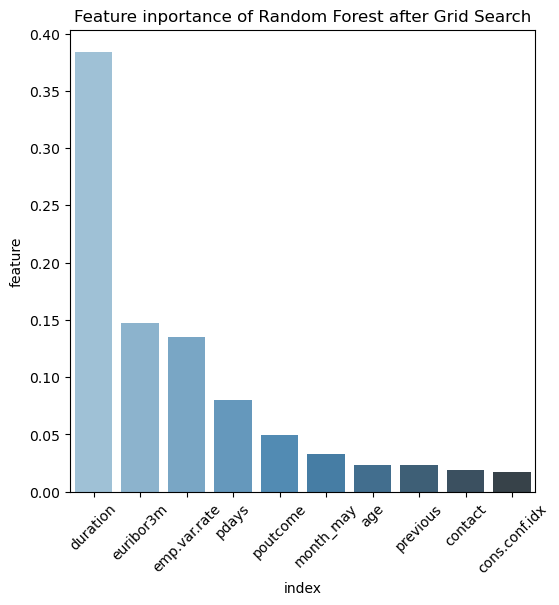

In [30]:
''' Build bar plot of feature importance of the best model '''

def build_feature_importance(model, X_train, y_train):
    
    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(RandomForestClassifier, X_train, y_train)

In [31]:


def build_feature_importance(model, X_train, y_train):
    # Train the model
    model = joblib.load('./save_models/Neural Net.pkl')
    # model.fit(X_train, y_train)
    # Get feature importances
    perm = PermutationImportance(model, random_state=1).fit(X_train,y_train)
    return eli5.show_weights(perm, feature_names = X_train.columns.tolist())

    # # Create dataframe
    # feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
    # # Sort by importance
    # feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
    # # Plot top 10 features
    # plt.figure(figsize=[6,6])
    # sns.barplot(x='feature', y='importance', data=feature_importances.head(10), palette="Blues_d")
    # plt.title('Feature Importance of Neural Network Model')
    # plt.xticks(rotation=45)
    # plt.show()

In [32]:
# Get the best params
#best_params = model.best_params_
model = KerasClassifier(build_fn=create_nn,epochs=5, batch_size=10, verbose=0 )
build_feature_importance(model, X_train, y_train)

Weight,Feature
0.0467 ± 0.0030,euribor3m
0.0297 ± 0.0016,duration
0.0085 ± 0.0006,poutcome
0.0058 ± 0.0006,month_may
0.0011 ± 0.0004,month_apr
0.0008 ± 0.0003,month_mar
0.0006 ± 0.0001,default
0.0006 ± 0.0006,emp.var.rate
0.0005 ± 0.0004,contact
0.0004 ± 0.0002,job_retired


In [ ]:
best_params_lr = gs_lr.best_params_
best_params_rf = gs_rf.best_params_
best_params_knn = gs_knn.best_params_ 
best_params_dt = gs_dt.best_params_ 
best_params_bag = gs_bag.best_params_
best_params_sgd = gs_sgd.best_params_
best_params_nn = gs_nn.best_params_
# print(best_params_lr, best_params_rf)
print(f"{best_params_lr}\n{best_params_rf}\n{best_params_knn}\n{best_params_dt}\n{best_params_bag}\n{best_params_sgd}\n{best_params_nn}")


{'lr__C': 0.6, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
{'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
{'knn__n_neighbors': 16}
{'dt__max_depth': 8, 'dt__min_samples_leaf': 3}
{'bag__n_estimators': 20}
{'sgd__alpha': 0.1, 'sgd__eta0': 0.001, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
{'NN__activation': 'relu', 'NN__batch_size': 10, 'NN__dropout_rate': 0.1, 'NN__epochs': 6, 'NN__optimizer': 'adam'}


In [39]:
# !pip install joblib 
print(os.getcwd())
import joblib 
model = joblib.load('C:/Users/Roland/General/Downloads/home/save_models/knn.pkl')
model

C:\Users\Roland\General\Downloads\home


Pipeline(steps=[('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=16))])

http request from flask/django endpoint 
predict endpoint - joblib.load model 
pass parameters
return
- Docker image and model object/flask-django server to Kubernetes (train image)
- weights